Creating a Teeth Segmentation object detection model using detetron2
===

Transform_json_for_detectron2
---

Check json file format

In [1]:
import json

# replace with the path of one of your json files
json_path = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann/1.jpg.json"

with open(json_path, 'r') as file:
    data = json.load(file)

print(json.dumps(data, indent=4))

{
    "description": "",
    "tags": [],
    "size": {
        "height": 1024,
        "width": 2041
    },
    "objects": [
        {
            "id": 1166088923,
            "classId": 11382893,
            "description": "",
            "geometryType": "polygon",
            "labelerLogin": "GhazalehHITL",
            "createdAt": "2023-01-24T09:03:34.164Z",
            "updatedAt": "2023-01-24T09:03:34.164Z",
            "tags": [],
            "classTitle": "8",
            "points": {
                "exterior": [
                    [
                        963,
                        587
                    ],
                    [
                        964,
                        569
                    ],
                    [
                        968,
                        546
                    ],
                    [
                        971,
                        524
                    ],
                    [
                        974,
              

key = 'classTitle' 추출하기

In [2]:
import os
import json

def get_key_value(json_str, key):
    data = json.loads(json_str)
    values = [obj[key] for obj in data['objects']]
    return values

def get_all_key_values(directory, key):
    all_values = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as file:
                json_str = file.read()
                values = get_key_value(json_str, key)
                all_values.extend(values)

    # Remove duplicates by converting the list to a set, then convert it back to a list
    all_values = list(set(all_values))
    # Sort the list in ascending order
    all_values = sorted(all_values)
    return all_values

# Test the function
directory_path = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann"
key = 'classTitle'
key_classTitle = get_all_key_values(directory_path, key)
print(key_classTitle)


['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '4', '5', '6', '7', '8', '9']


transform json format 

In [4]:
import os
import json
import glob
import cv2
from PIL import Image

def get_bbox(points):
    x_coordinates = [point[0] for point in points]
    y_coordinates = [point[1] for point in points]
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def transform_to_coco_format(json_files):
    coco_format_json = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    annotation_id = 1
    category_id_set = set()

    for image_id, json_file in enumerate(json_files, start=1):
        with open(json_file, 'r') as file:
            data = json.load(file)

        image_info = {
            "id": image_id,
            "file_name": os.path.basename(json_file).replace(".json", ''),
            "width": data["size"]["width"],
            "height": data["size"]["height"]
        }

        coco_format_json["images"].append(image_info)

        for obj in data["objects"]:
            category_id = int(obj["classTitle"])
            category_id_set.add(category_id)
            
            annotation_info = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": get_bbox(obj["points"]["exterior"]),
                "area": 0,  # You may calculate the actual area if necessary
                "iscrowd": 0
            }

            coco_format_json["annotations"].append(annotation_info)
            annotation_id += 1

    for category_id in category_id_set:
        category_info = {
            "id": category_id,
            "name": str(category_id)
        }
        coco_format_json["categories"].append(category_info)
        
    return coco_format_json

# Specify your directories
json_dir = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/ann"
output_file = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"

# Get all the JSON files in the input directory
json_files = glob.glob(os.path.join(json_dir, "*.json"))

# Transform JSON files to COCO format
coco_format_json = transform_to_coco_format(json_files)

# Save the COCO format data to the output directory
with open(output_file, "w") as f:
    json.dump(coco_format_json, f, indent=4)

print(f"COCO format JSON saved: {output_file}")


COCO format JSON saved: ./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json


Detectron2 model setting
---

In [5]:
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Assuming the data is in COCO format and the path to the json file and images are known
json_file = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"
image_root = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/img"

dataset_name = "teeth_train"
# Remove existing registration if it exists
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

register_coco_instances(dataset_name, {}, json_file, image_root)

json_file_val = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/dataset_ann/coco_format.json"
image_root_val = "./Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2/img"

dataset_name_val = "teeth_test"
# Remove existing registration if it exists
if dataset_name_val in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name_val)
    MetadataCatalog.remove(dataset_name_val)

register_coco_instances(dataset_name_val, {}, json_file_val, image_root_val)


Detectron2 model training
---

Check the location of the detectron2 model

In [22]:
import glob

file_path = None

# Search for the file in the file system
for file in glob.glob("**/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml", recursive=True):
    file_path = file
    break  # Stop searching after finding the first occurrence

if file_path is not None:
    directory = file_path.rsplit("/", 1)[0]
    print("Directory containing 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml':", directory)
else:
    print("'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' not found.")


Directory containing 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml': configs/COCO-Detection


Using "CPU"
---

HERE!!!!!!!!!!!!!!!!!!!
COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
[07/13 20:53:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2),

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (124, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (124,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[07/13 20:53:05 d2.engine.train_loop]: Starting training from iteration 0
[07/13 20:54:30 d2.utils.events]:  eta: 3:31:35  iter: 19  total_loss: 4.808  loss_cls: 3.524  loss_box_reg: 0.8043  loss_rpn_cls: 0.3017  loss_rpn_loc: 0.1787    time: 4.2055  last_time: 4.4311  data_time: 0.0084  last_data_time: 0.0028   lr: 4.9953e-06  
[07/13 20:55:55 d2.utils.events]:  eta: 3:31:18  iter: 39  total_loss: 4.604  loss_cls: 3.412  loss_box_reg: 0.7961  loss_rpn_cls: 0.2227  loss_rpn_loc: 0.1803    time: 4.2262  last_time: 3.7773  data_time: 0.0024  last_data_time: 0.0025   lr: 9.9902e-06  
[07/13 20:57:13 d2.utils.events]:  eta: 3:19:36  iter: 59  total_loss: 4.343  loss_cls: 3.185  loss_box_reg: 0.8408  loss_rpn_cls: 0.1464  loss_rpn_loc: 0.1748    time: 4.1099  last_time: 3.6941  data_time: 0.0025  last_data_time: 0.0023   lr: 1.4985e-05  
[07/13 20:58:32 d2.utils.events]:  eta: 3:16:59  iter: 79  total_loss: 3.895  loss_cls: 2.813  loss_box_reg: 0.8418  loss_rpn_cls: 0.07286  loss_rpn_loc: 0

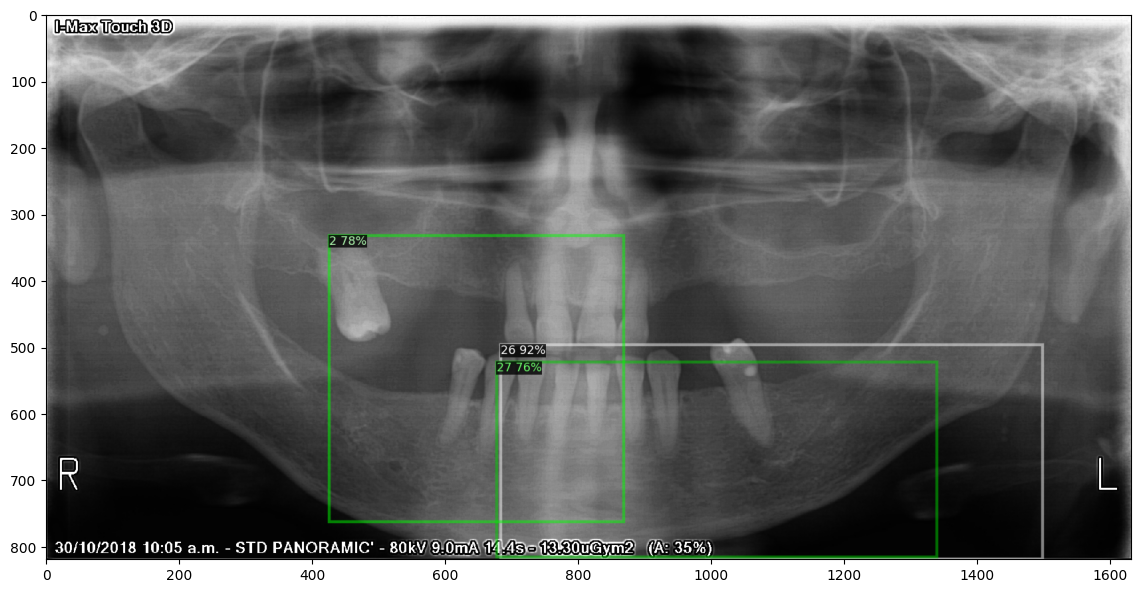

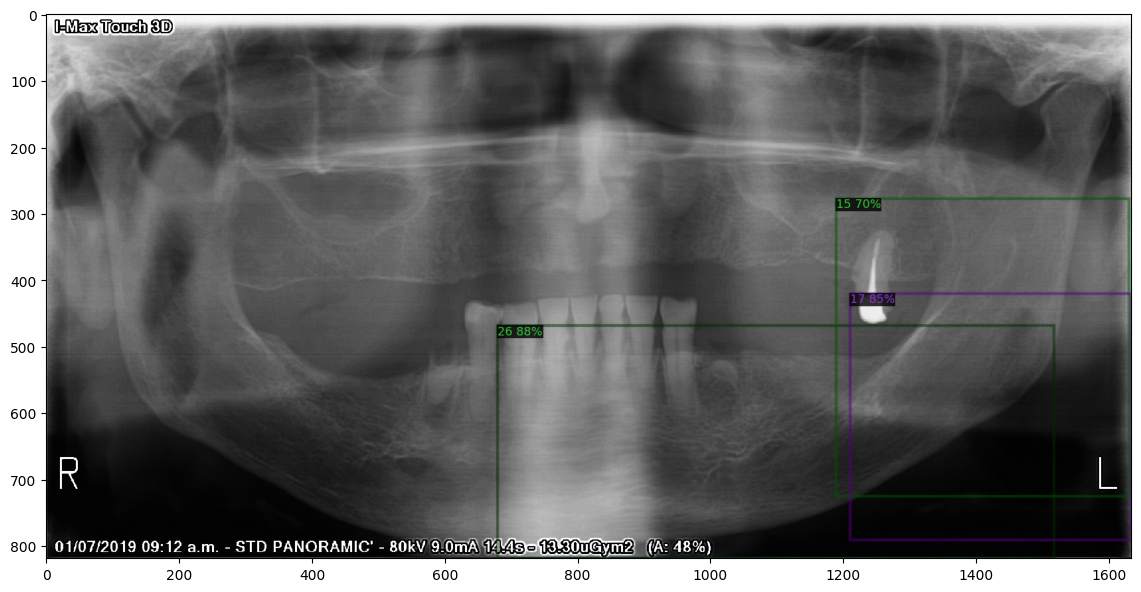

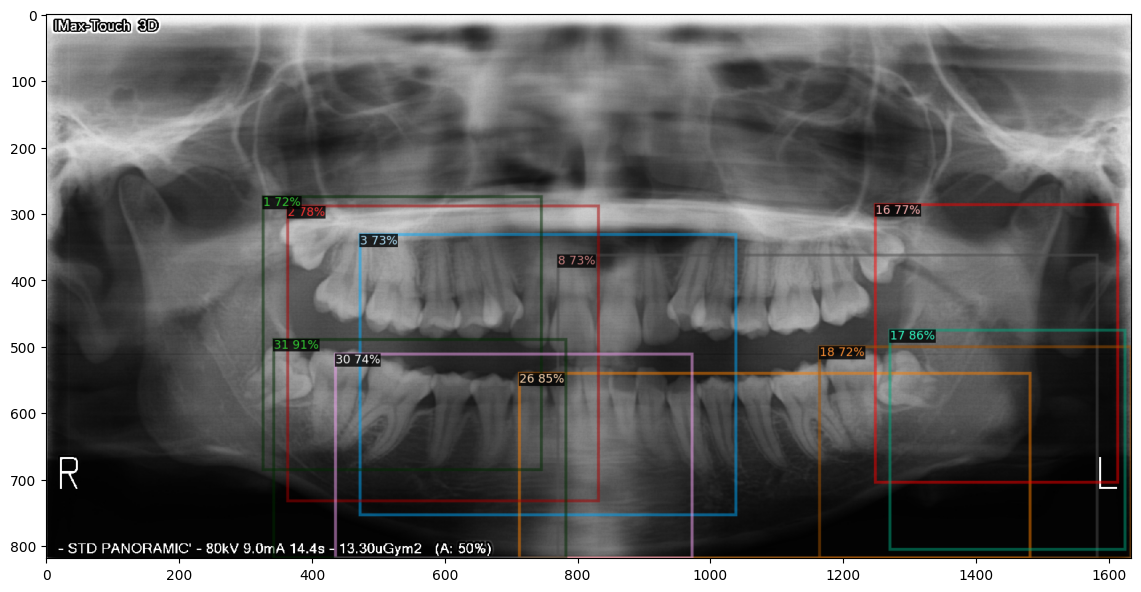

In [7]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2 import model_zoo

import cv2
import matplotlib.pyplot as plt
import os
import random

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the dataset name for training
cfg.DATASETS.TEST = ("teeth_test",)  # Use the dataset name for testing
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 31  # Set the number of classes based on your dataset
cfg.MODEL.DEVICE = 'cpu'  # Use CPU instead of GPU

# Step 3: Train the model
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()



Using GPU
---

In [11]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor, DefaultTrainer
import os
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

# Step 1: Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("teeth_train",)  # Use the train dataset we defined earlier
cfg.DATASETS.TEST = ("teeth_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights

# Step 2: Set up the training parameters
cfg.OUTPUT_DIR = './Teeth_Segmentation_on_dental_Xray_images/Teeth_Segmentation_JSON/d2'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Train for this many iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes based on your dataset

# Step 3: Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Step 4: Test the model
evaluator = COCOEvaluator("teeth_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "teeth_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Step 5: Visualize the predictions
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Use the final weights from training
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the testing threshold
predictor = DefaultPredictor(cfg)

test_metadata = MetadataCatalog.get("teeth_test")

for d in random.sample(DatasetCatalog.get("teeth_test"), 3):  # Randomly select data
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()


HERE!!!!!!!!!!!!!!!!!!!
COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW